In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import os, os.path 
import numpy 
import pickle
from glob import glob
from tqdm import tqdm


"""Change to the data folder"""
new_path = "data/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)

In [3]:
batch_sz = 100
import numpy as np
import random


def my_collate_train(batch):
    """collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature]"""

    batch_inp = []
    batch_out = []

    for scene in batch:
        agent = scene["agent_id"]
        target = 0
        for x in range(len(scene["track_id"])):
            if scene["track_id"][x][0] == agent:
                target = x
        inp = [scene["p_in"][target], scene["v_in"][target]]
        out = [scene["p_out"][target], scene["v_out"][target]]
        batch_inp.append(inp)
        batch_out.append(out)

    # scene level #####################
    # batch_inp = []
    # batch_out = []
    # for scene in batch:
    #   mask = scene['car_mask'].flatten()==1
    #   # print(np.count_nonzero(mask))
    #   inp = [scene['p_in'][mask], scene['v_in'][mask]]
    #   out = [scene['p_out'][mask], scene['v_out'][mask]]
    #   batch_inp.append(inp)
    #   batch_out.append(out)
    ####################################

    inp = torch.FloatTensor(batch_inp)
    out = torch.FloatTensor(batch_out)
    return [inp, out]


def my_collate_train_multiple(batch):
    """collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature]"""

    batch_inp = []
    batch_out = []

    for scene in batch:
        agent = scene["agent_id"]
        target = 0
        for x in range(len(scene["track_id"])):
            if scene["track_id"][x][0] == agent:
                target = x
        inp = [scene["p_in"][target], scene["v_in"][target]]
        out = [scene["p_out"][target], scene["v_out"][target]]

        other_in = np.zeros((5, 2, 19, 2))  # need to permute to 2,5,19,2 later
        other_out = np.zeros((5, 2, 30, 2))

        other_in[0] = inp
        other_out[0] = out

        mask = scene["car_mask"].flatten() == 1
        mask = np.delete(mask, target)
        mask = np.where(mask == True)[0]

        if len(mask) >= 4:
            temp = random.sample(mask.tolist(), 4)
            for i in range(len(temp)):
                other_in[i + 1] = [scene["p_in"][temp[i]], scene["v_in"][temp[i]]]
                other_out[i + 1] = [scene["p_out"][temp[i]], scene["v_out"][temp[i]]]
        else:
            for i in range(len(mask)):
                other_in[i + 1] = [scene["p_in"][mask[i]], scene["v_in"][mask[i]]]
                other_out[i + 1] = [scene["p_out"][mask[i]], scene["v_out"][mask[i]]]
            for i in range(4 - len(mask)):
                other_in[i + 1 + len(mask)] = inp
                other_out[i + 1 + len(mask)] = out

        batch_inp.append(other_in.tolist())
        batch_out.append(other_out.tolist())

    # scene level #####################
    # batch_inp = []
    # batch_out = []
    # for scene in batch:
    #   mask = scene['car_mask'].flatten()==1
    #   # print(np.count_nonzero(mask))
    #   inp = [scene['p_in'][mask], scene['v_in'][mask]]
    #   out = [scene['p_out'][mask], scene['v_out'][mask]]
    #   batch_inp.append(inp)
    #   batch_out.append(out)
    ####################################

    inp = torch.FloatTensor(batch_inp)
    inp = inp.permute(2, 0, 1, 3, 4)  # p/v, batch, cars, points, x/y
    out = torch.FloatTensor(batch_out)
    out = out.permute(2, 0, 1, 3, 4)
    return [inp, out]


def my_collate_val(batch):
    """collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature]"""

    inp = [[scene["p_in"], scene["v_in"]] for scene in batch]
    mask = [scene["car_mask"] for scene in batch]

    inp = torch.FloatTensor(inp)
    mask = torch.FloatTensor(mask)
    return [inp, mask]

In [ ]:
'''
start with initial 19 points and zero fill remaining
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Trajectory(nn.Module):

    def __init__(self):
        super(Trajectory, self).__init__()

        self.p_in = nn.Linear(2,32) # N, 19, 2
        self.v_in = nn.Linear(2,32) # N, 19, 2
        
        self.encoder = nn.LSTM(64, 64, 1) # input 19, N, 64 output 1, N, 64 

        self.decoder_p = nn.LSTM(64, 64, 1) # input 30, N, 64 output 30, N, 64
        self.decoder_v = nn.LSTM(64, 64,1) # input 30, N, 64 output 30, N, 64

        self.p_out = nn.Linear(128,2)
        self.v_out = nn.Linear(128,2)

    def forward(self, p, v):
        batch = p.shape[0]
        x_p = self.p_in(p)
        x_v = self.v_in(v)

        x = torch.cat((x_p,x_v),dim=2)
        x = x.permute(1,0,2)

        _,(state_h) = self.encoder(x)

        temp = torch.zeros(11,batch,64)
        x = torch.cat((x,temp),dim=0)

        x_p,_ = self.decoder_p(x,state_h)
        x_v,_ = self.decoder_v(x,state_h)

        x_p = x_p.permute(1,0,2)
        x_v = x_v.permute(1,0,2)

        x_p = self.p_out(x_p)
        x_v = self.v_out(x_v)

        # batch 50, 345s per epoch
        # p to p -> 9.21 after 10 epochs
        # p + v to p -> 8.8 after 10 epochs
        # p + v to p +v -> 6.65 after 10 epochs

        # batch 100, 345s per epoch
        # p + v to p +v -> 4.5 after 10 epochs

        return x_p , x_v

In [ ]:
'''
Recursive per point
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Trajectory(nn.Module):

    def __init__(self):
        super(Trajectory, self).__init__()

        self.p_in = nn.Linear(2,32) # N, 19, 2
        self.v_in = nn.Linear(2,32) # N, 19, 2
        
        self.encoder = nn.LSTM(64, 64, 1) # input 19, N, 64 output 1, N, 64 

        self.decoder_p = nn.LSTM(64, 64, 1) # input 30, N, 64 output 30, N, 64
        self.decoder_v = nn.LSTM(64, 64,1) # input 30, N, 64 output 30, N, 64

        self.recurse_p =  nn.Linear(2,32)
        self.recurse_v = nn.Linear(2,32)
 
        self.p_out = nn.Linear(64,2)
        self.v_out = nn.Linear(64,2)

    def forward(self, p, v):
        batch = p.shape[0]
        x_p = self.p_in(p)
        x_v = self.v_in(v)

        x = torch.cat((x_p,x_v),dim=2)
        x = x.permute(1,0,2)

        _,(state_h) = self.encoder(x)

        temp_p = torch.zeros(30,batch,2).to(device) # output of p
        temp_v = torch.zeros(30,batch,2).to(device)
       
        decoder_p_inp = torch.unsqueeze(x[-1],0)
        decoder_v_inp = torch.unsqueeze(x[-1],0)
        state_p = state_h
        state_v = state_h

        for i in range(30):
          x_p,state_p = self.decoder_p(decoder_p_inp, state_p)
          x_v,state_v = self.decoder_v(decoder_v_inp, state_v)

          x_p = self.p_out(x_p)
          x_v = self.v_out(x_v)

          temp_p[i] = x_p
          temp_v[i] = x_v

          x_p = self.recurse_p(x_p)
          x_v = self.recurse_v(x_v)

          x = torch.cat((x_p,x_v),dim=2)

          decoder_p_inp = x
          decoder_v_inp = x

        temp_p = temp_p.permute(1,0,2)
        temp_v = temp_v.permute(1,0,2)
        return temp_p, temp_v

In [4]:
'''
Edward's Tests, bigger
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiggerTrajectory(nn.Module):

    def __init__(self):
        super(BiggerTrajectory, self).__init__()

        self.p_in = nn.Linear(2,32) # N, 19, 2
        self.v_in = nn.Linear(2,32) # N, 19, 2
        
        self.encoder = nn.LSTM(64, 128, 1) # input 19, N, 64 output 19, N, 128
        self.encoder_2 = nn.LSTM(128, 128, 1) # output 1, N, 128

        self.decoder_p = nn.LSTM(128, 256, 1) # input 30, N, 128 output 30, N, 256
        self.decoder_p_2 = nn.LSTM(256, 256, 1) # input 30, N, 256 output 30, N, 256

        self.decoder_v = nn.LSTM(128, 256,1) # input 30, N, 128 output 30, N, 256
        self.decoder_v_2 = nn.LSTM(256, 256,1) # input 30, N, 256 output 30, N, 256

        self.p_out = nn.Linear(256,128)
        self.p_out_2 = nn.Linear(128,2)
        self.v_out = nn.Linear(256,128)
        self.v_out_2 = nn.Linear(128,2)

    def forward(self, p, v):
        batch = p.shape[0]
        
        x_p = self.p_in(p)
        x_v = self.v_in(v)

        x = torch.cat((x_p,x_v),dim=2)
        x = x.permute(1,0,2)

        x, _ = self.encoder(x)
        _,(state_h,_) = self.encoder_2(x)

        x = state_h.repeat(30,1,1)     

        x_p,_ = self.decoder_p(x)
        x_p,_ = self.decoder_p_2(x_p)

        x_v,_ = self.decoder_v(x)
        x_v,_ = self.decoder_v_2(x_v)

        x_p = x_p.permute(1,0,2)
        x_v = x_v.permute(1,0,2)

        x_p = F.relu(self.p_out(x_p))
        x_p = self.p_out_2(x_p)

        x_v = F.relu(self.v_out(x_v))
        x_v = self.v_out_2(x_v)


        # batch 50, 345s per epoch
        # p to p -> 9.21 after 10 epochs
        # p + v to p -> 8.8 after 10 epochs
        # p + v to p +v -> 6.65 after 10 epochs

        # batch 100, 345s per epoch
        # p + v to p +v -> 4.5 after 10 epochs

        return x_p , x_v

In [5]:
'''
original network
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NaiveTrajectory(nn.Module):

    def __init__(self):
        super(NaiveTrajectory, self).__init__()

        self.p_in = nn.Linear(2,32) # N, 19, 2
        self.v_in = nn.Linear(2,32) # N, 19, 2
        
        self.encoder = nn.LSTM(64, 64, 1) # input 19, N, 64 output 1, N, 64 

        self.decoder_p = nn.LSTM(64, 128, 1) # input 30, N, 64 output 30, N, 128
        self.decoder_v = nn.LSTM(64, 128,1) # input 30, N, 64 output 30, N, 128

        self.p_out = nn.Linear(128,2)
        self.v_out = nn.Linear(128,2)

    def forward(self, p, v):
        batch = p.shape[0]
        x_p = self.p_in(p)
        x_v = self.v_in(v)

        x = torch.cat((x_p,x_v),dim=2)
        x = x.permute(1,0,2)

        _,(state_h,_) = self.encoder(x)

        x = state_h.repeat(30,1,1).to(device)     

        x_p,_ = self.decoder_p(x)
        x_v,_ = self.decoder_v(x)

        x_p = x_p.permute(1,0,2)
        x_v = x_v.permute(1,0,2)

        x_p = self.p_out(x_p)
        x_v = self.v_out(x_v)

        # batch 50, 345s per epoch
        # p to p -> 9.21 after 10 epochs
        # p + v to p -> 8.8 after 10 epochs
        # p + v to p +v -> 6.65 after 10 epochs

        # batch 100, 345s per epoch
        # p + v to p +v -> 4.5 after 10 epochs

        return x_p , x_v

In [6]:
'''
Edward's Tests, bigger, bigger
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BigBigTrajectory(nn.Module):

    def __init__(self):
        super(BigBigTrajectory, self).__init__()

        self.p_in = nn.Linear(2,32) # N, 19, 2
        self.v_in = nn.Linear(2,32) # N, 19, 2
        
        self.encoder = nn.LSTM(64, 128, 1) # input 19, N, 64 output 19, N, 128
        self.encoder_2 = nn.LSTM(128, 128, 1) # output 1, N, 128

        self.translate = nn.Linear(128,256) # translation

        self.decoder_p = nn.LSTM(256, 512, 1) # input 30, N, 128 output 30, N, 256
        self.decoder_p_2 = nn.LSTM(512,512, 1) # input 30, N, 256 output 30, N, 256

        self.decoder_v = nn.LSTM(256, 512,1) # input 30, N, 128 output 30, N, 256
        self.decoder_v_2 = nn.LSTM(512, 512,1) # input 30, N, 256 output 30, N, 256

        self.p_out = nn.Linear(512,256)
        self.p_out_2 = nn.Linear(256,2)
        self.v_out = nn.Linear(512,256)
        self.v_out_2 = nn.Linear(256,2)

    def forward(self, p, v):
        batch = p.shape[0]
        
        x_p = self.p_in(p)
        x_v = self.v_in(v)

        x = torch.cat((x_p,x_v),dim=2)
        x = x.permute(1,0,2)

        x, _ = self.encoder(x)
        _,(state_h,_) = self.encoder_2(x)

        state_h = self.translate(state_h)

        x = state_h.repeat(30,1,1)     

        x_p,_ = self.decoder_p(x)
        x_p,_ = self.decoder_p_2(x_p)

        x_v,_ = self.decoder_v(x)
        x_v,_ = self.decoder_v_2(x_v)

        x_p = x_p.permute(1,0,2)
        x_v = x_v.permute(1,0,2)

        x_p = F.relu(self.p_out(x_p))
        x_p = self.p_out_2(x_p)

        x_v = F.relu(self.v_out(x_v))
        x_v = self.v_out_2(x_v)


        # batch 50, 345s per epoch
        # p to p -> 9.21 after 10 epochs
        # p + v to p -> 8.8 after 10 epochs
        # p + v to p +v -> 6.65 after 10 epochs

        # batch 100, 345s per epoch
        # p + v to p +v -> 4.5 after 10 epochs

        return x_p , x_v


In [ ]:
'''
start with initial 19 points and zero fill remaining, bigger
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Trajectory(nn.Module):

    def __init__(self):
        super(Trajectory, self).__init__()

        self.p_in = nn.Linear(2,64) # N, 19, 2
        self.v_in = nn.Linear(2,64) # N, 19, 2
        
        self.convert = nn.Linear(128,256)

        self.encoder = nn.LSTM(128,256,1)
        self.encoder_2 = nn.LSTM(256, 256, 1) # input 19, N, 256 output 1, N, 256

        self.decoder_p = nn.LSTM(256, 256, 1) 
        self.decoder_p_2 = nn.LSTM(256, 512, 1) 

        self.decoder_v = nn.LSTM(256, 256,1) 
        self.decoder_v_2 = nn.LSTM(256, 512,1) 

        self.p_out = nn.Linear(512,256)
        self.p_out_2 = nn.Linear(256,2)
        self.v_out = nn.Linear(512,256)
        self.v_out_2 = nn.Linear(256,2)


    def forward(self, p, v):
        batch = p.shape[0]
        x_p = self.p_in(p)
        x_v = self.v_in(v)

        x = torch.cat((x_p,x_v),dim=2)
        x = x.permute(1,0,2)

        x_temp,_ = self.encoder(x)
        _,(state_h) = self.encoder_2(x_temp)

        temp = torch.zeros(11,batch,128).to(device)

        x = torch.cat((x,temp),dim=0)

        x = self.convert(x)

        x_p,_ = self.decoder_p(x,state_h)
        x_p,_ = self.decoder_p_2(x_p)

        x_v,_ = self.decoder_v(x,state_h)
        x_v,_ = self.decoder_v_2(x_v)

        x_p = x_p.permute(1,0,2)
        x_v = x_v.permute(1,0,2)

        x_p = F.relu(self.p_out(x_p))
        x_p = self.p_out_2(x_p)

        x_v = F.relu(self.v_out(x_v))
        x_v = self.v_out_2(x_v)


        # batch 50, 345s per epoch
        # p to p -> 9.21 after 10 epochs
        # p + v to p -> 8.8 after 10 epochs
        # p + v to p +v -> 6.65 after 10 epochs

        # batch 100, 345s per epoch
        # p + v to p +v -> 4.5 after 10 epochs

        return x_p , x_v

In [ ]:
# don't run

import numpy as np
model = Trajectory().double()
print(model)

p = np.zeros((4,19,2))
v = np.zeros((4,19,2))
p_torch = torch.tensor(p)
v_torch = torch.tensor(v)

output = model(p_torch,v_torch)
print(len(output))
print(output[0].shape)

In [ ]:
import time
from tqdm import tqdm

batch_sz = 100
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train,
    num_workers=2,
)

train_size = int(0.8 * len(train_loader.dataset))
val_size = len(train_loader.dataset) - train_size
train_data, val_data = torch.utils.data.random_split(
    train_loader.dataset, [train_size, val_size]
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_loader.dataset))
print("LENGTH OF TRAIN DATA:", len(train_data), "\nLENGTH OF VAL DATA:", len(val_data))

train_data = DataLoader(
    train_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train,
    num_workers=2,
)
val_data = DataLoader(
    val_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train,
    num_workers=2,
)
model = Trajectory().to(device)

my_optim = torch.optim.Adam(model.parameters(), lr=0.001)

# decayRate = 0.999
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)

epoch = 20  # takes around 20 epochs to converge
number = 1  # number of cars in each

for i in range(epoch):

    model.train()
    epoch_loss = 0
    start = time.time()

    train_loop = tqdm(enumerate(train_data), total=len(train_data))

    for i_batch, sample_batch in train_loop:
        inp, out = sample_batch
        batch = inp.shape[0]

        p_in = (
            inp[:, 0].reshape(batch * number, 19, 2).to(device)
        ) / 4800.0  # -2400.)/2400.
        v_in = inp[:, 1].reshape(batch * number, 19, 2).to(device) / 100.0
        p_out = (
            out[:, 0].reshape(batch * number, 30, 2).to(device)
        ) / 4800.0  # -2400.)/2400.
        v_out = out[:, 1].reshape(batch * number, 30, 2).to(device) / 100.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        v_criteria = nn.MSELoss()
        v_loss = torch.sqrt(v_criteria(pred[1], v_out))

        loss = p_loss + v_loss
        epoch_loss += p_loss

        my_optim.zero_grad()
        loss.backward()
        my_optim.step()

        train_loop.set_description(f"Train Epoch [{i + 1}/{epoch}]")
        train_loop.set_postfix(loss=epoch_loss.item())
        # my_lr_scheduler.step()
        # if(i>2999):
        #   # print(pred[0]*2400.+2400., p_out[0]*2400.+2400.)
        #   print(pred[0]*4800., p_out[0]*4800.)
        # break
    # print("Training Loss: ", i, epoch_loss.item(), time.time() - start)

    model.eval()
    epoch_loss = 0
    val_loop = tqdm(enumerate(val_data), total=len(val_data))
    for i_batch, sample_batch in val_loop:
        inp, out = sample_batch
        batch = inp.shape[0]

        p_in = (inp[:, 0].reshape(batch * number, 19, 2).to(device)) / 4800.0
        v_in = inp[:, 1].reshape(batch * number, 19, 2).to(device) / 100.0
        p_out = (out[:, 0].reshape(batch * number, 30, 2).to(device)) / 4800.0
        v_out = out[:, 1].reshape(batch * number, 30, 2).to(device) / 100.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        epoch_loss += p_loss

        val_loop.set_description(f"Val.  Epoch [{i + 1}/{epoch}]")
        val_loop.set_postfix(loss=epoch_loss.item())
    # print("Validation Loss: ", epoch_loss.item())

# Model Training and Validation
---
1. Naive Model
2. Bigger Model
3. "Bigger Bigger" Model

In [7]:
train_naive = []
val_naive = []

train_bigger = []
val_bigger = []

train_bb = []
val_bb = []

In [7]:
def zeroNormNP(array, size=19, pos=np.array([-1, -1])):  # array is N,19,2
    temp = []
    if np.array_equal(pos, np.array([-1, -1])):
        temp = array[:, 0]
    else:
        temp = pos  # should be N,2
    temp = np.expand_dims(temp, 1)
    temp = np.repeat(temp, size, 1)

    return (array - temp) / 200.0, array[:, 0]


def zeroNormTor(array, size=19, pos=torch.tensor([-1, -1])):  # array is N,19,2
    temp = []
    if np.array_equal(pos, torch.tensor([-1, -1])):
        temp = array[:, 0]
    else:
        temp = pos  # should be N,2
    temp = torch.unsqueeze(temp, 1)
    temp = torch.repeat_interleave(temp, size, 1)
    return (array - temp) / 200.0, array[:, 0]

In [9]:
'''
Naive
/200
30 epochs
5 Cars
'''
import time

batch_sz = 100
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)

train_size = int(0.8 * len(train_loader.dataset))
val_size = len(train_loader.dataset) - train_size
train_data, val_data = torch.utils.data.random_split(
    train_loader.dataset, [train_size, val_size]
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_loader.dataset))
print("LENGTH OF TRAIN DATA:", len(train_data), "\nLENGTH OF VAL DATA:", len(val_data))

train_data = DataLoader(
    train_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
val_data = DataLoader(
    val_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
model = NaiveTrajectory().to(device)

my_optim = torch.optim.Adam(model.parameters(), lr=0.001)

# decayRate = 0.999
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)

epoch = 30  # takes around 20 epochs to converge
number = 5  # number of cars in each

best_val = 100

for i in range(epoch):

    model.train()
    epoch_loss = 0
    start = time.time()

    train_loop = tqdm(enumerate(train_data), total=len(train_data))

    for i_batch, sample_batch in train_loop:

        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        v_criteria = nn.MSELoss()
        v_loss = torch.sqrt(v_criteria(pred[1], v_out))

        loss = p_loss + v_loss
        epoch_loss += p_loss.item()
        
        avg_train_loss = epoch_loss / len(train_data)

        my_optim.zero_grad()
        loss.backward()
        my_optim.step()

        train_loop.set_description(f"Train Epoch [{i + 1}/{epoch}]")
        train_loop.set_postfix(loss = epoch_loss, avg = avg_train_loss)        
    
    train_naive.append(avg_train_loss) # append final average train loss
    
    model.eval()
    epoch_loss = 0
    val_loop = tqdm(enumerate(val_data), total=len(val_data))
    for i_batch, sample_batch in val_loop:
        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        epoch_loss += p_loss.item()
        
        avg_val_loss = epoch_loss / len(val_data)

        val_loop.set_description(f"Val.  Epoch [{i + 1}/{epoch}]")
        val_loop.set_postfix(loss = epoch_loss, avg = avg_val_loss)
    
    val_naive.append(avg_val_loss) # append final average val loss
    
    if epoch_loss < best_val:
        filename = "naive_best.pth"
        state = {
            "epoch": i,
            "state_dict": model.state_dict(),
            "optimizer": my_optim.state_dict(),
        }
        torch.save(state, filename)
        print("saved")
        best_val = epoch_loss

    #print("Validation Loss: ", epoch_loss)


LENGTH OF TRAIN LOADER DATASET: 205942
LENGTH OF TRAIN DATA: 164753 
LENGTH OF VAL DATA: 41189


Val.  Epoch [1/30]: 100%|██████████| 412/412 [00:14<00:00, 29.39it/s, avg=0.0126, loss=5.2]   

saved



Val.  Epoch [2/30]: 100%|██████████| 412/412 [00:13<00:00, 29.83it/s, avg=0.0117, loss=4.82]  

saved



Val.  Epoch [7/30]: 100%|██████████| 412/412 [00:12<00:00, 31.90it/s, avg=0.0115, loss=4.74]  

saved



Val.  Epoch [8/30]: 100%|██████████| 412/412 [00:14<00:00, 29.37it/s, avg=0.0109, loss=4.48]  

saved



Val.  Epoch [9/30]: 100%|██████████| 412/412 [00:13<00:00, 29.76it/s, avg=0.0107, loss=4.4]   

saved



Val.  Epoch [10/30]: 100%|██████████| 412/412 [00:13<00:00, 29.58it/s, avg=0.0106, loss=4.36]  

saved



Val.  Epoch [11/30]: 100%|██████████| 412/412 [00:14<00:00, 28.76it/s, avg=0.0105, loss=4.33]  

saved



Val.  Epoch [12/30]: 100%|██████████| 412/412 [00:14<00:00, 27.91it/s, avg=0.0104, loss=4.27]  

saved



Val.  Epoch [15/30]: 100%|██████████| 412/412 [00:14<00:00, 29.13it/s, avg=0.0103, loss=4.25]  


saved


Val.  Epoch [16/30]: 100%|██████████| 412/412 [00:14<00:00, 29.35it/s, avg=0.0103, loss=4.24]  

saved



Val.  Epoch [17/30]: 100%|██████████| 412/412 [00:14<00:00, 28.92it/s, avg=0.0103, loss=4.23]  

saved



Val.  Epoch [18/30]: 100%|██████████| 412/412 [00:13<00:00, 29.95it/s, avg=0.0102, loss=4.21]  

saved



Val.  Epoch [20/30]: 100%|██████████| 412/412 [00:13<00:00, 30.17it/s, avg=0.0101, loss=4.17]  

saved



Val.  Epoch [21/30]: 100%|██████████| 412/412 [00:13<00:00, 29.71it/s, avg=0.01, loss=4.13]    


saved


Val.  Epoch [24/30]: 100%|██████████| 412/412 [00:13<00:00, 29.60it/s, avg=0.01, loss=4.12]    

saved



Val.  Epoch [25/30]: 100%|██████████| 412/412 [00:14<00:00, 29.18it/s, avg=0.00994, loss=4.09] 

saved



Val.  Epoch [30/30]: 100%|██████████| 412/412 [00:14<00:00, 28.73it/s, avg=0.00991, loss=4.08] 


saved


In [10]:
'''
Bigger
/200
30 epochs
5 Cars
'''
import time

batch_sz = 100
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)

train_size = int(0.8 * len(train_loader.dataset))
val_size = len(train_loader.dataset) - train_size
train_data, val_data = torch.utils.data.random_split(
    train_loader.dataset, [train_size, val_size]
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_loader.dataset))
print("LENGTH OF TRAIN DATA:", len(train_data), "\nLENGTH OF VAL DATA:", len(val_data))

train_data = DataLoader(
    train_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
val_data = DataLoader(
    val_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
model = BiggerTrajectory().to(device)

my_optim = torch.optim.Adam(model.parameters(), lr=0.001)

# decayRate = 0.999
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)

epoch = 30  # takes around 20 epochs to converge
number = 5  # number of cars in each

best_val = 100

for i in range(epoch):

    model.train()
    epoch_loss = 0
    start = time.time()

    train_loop = tqdm(enumerate(train_data), total=len(train_data))

    for i_batch, sample_batch in train_loop:

        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        v_criteria = nn.MSELoss()
        v_loss = torch.sqrt(v_criteria(pred[1], v_out))

        loss = p_loss + v_loss
        epoch_loss += p_loss.item()
        
        avg_train_loss = epoch_loss / len(train_data)

        my_optim.zero_grad()
        loss.backward()
        my_optim.step()

        train_loop.set_description(f"Train Epoch [{i + 1}/{epoch}]")
        train_loop.set_postfix(loss = epoch_loss, avg = avg_train_loss)        
    
    train_bigger.append(avg_train_loss) # append final average train loss
    
    model.eval()
    epoch_loss = 0
    val_loop = tqdm(enumerate(val_data), total=len(val_data))
    for i_batch, sample_batch in val_loop:
        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        epoch_loss += p_loss.item()
        
        avg_val_loss = epoch_loss / len(val_data)

        val_loop.set_description(f"Val.  Epoch [{i + 1}/{epoch}]")
        val_loop.set_postfix(loss = epoch_loss, avg = avg_val_loss)
    
    val_bigger.append(avg_val_loss) # append final average val loss
    
    if epoch_loss < best_val:
        filename = "big_best.pth"
        state = {
            "epoch": i,
            "state_dict": model.state_dict(),
            "optimizer": my_optim.state_dict(),
        }
        torch.save(state, filename)
        print("saved")
        best_val = epoch_loss

    #print("Validation Loss: ", epoch_loss)


LENGTH OF TRAIN LOADER DATASET: 205942
LENGTH OF TRAIN DATA: 164753 
LENGTH OF VAL DATA: 41189


Val.  Epoch [1/30]: 100%|██████████| 412/412 [00:14<00:00, 28.34it/s, avg=0.0127, loss=5.25]  


saved


Val.  Epoch [3/30]: 100%|██████████| 412/412 [00:14<00:00, 28.12it/s, avg=0.0125, loss=5.15]  


saved


Val.  Epoch [4/30]: 100%|██████████| 412/412 [00:14<00:00, 27.95it/s, avg=0.0121, loss=4.99]  


saved


Val.  Epoch [5/30]: 100%|██████████| 412/412 [00:14<00:00, 27.57it/s, avg=0.012, loss=4.95]   


saved


Val.  Epoch [6/30]: 100%|██████████| 412/412 [00:14<00:00, 28.23it/s, avg=0.0117, loss=4.8]   


saved


Val.  Epoch [7/30]: 100%|██████████| 412/412 [00:14<00:00, 27.75it/s, avg=0.0114, loss=4.69]  


saved


Val.  Epoch [8/30]: 100%|██████████| 412/412 [00:14<00:00, 28.27it/s, avg=0.0109, loss=4.51]  


saved


Val.  Epoch [10/30]: 100%|██████████| 412/412 [00:14<00:00, 28.24it/s, avg=0.0108, loss=4.45]  


saved


Val.  Epoch [25/30]: 100%|██████████| 412/412 [00:16<00:00, 25.48it/s, avg=0.0107, loss=4.41]  


saved


Val.  Epoch [29/30]: 100%|██████████| 412/412 [00:15<00:00, 27.24it/s, avg=0.0103, loss=4.25]  


saved


Val.  Epoch [30/30]: 100%|██████████| 412/412 [00:15<00:00, 27.26it/s, avg=0.0104, loss=4.3]   


In [11]:
'''
Big Big
/200
30 epochs
5 Cars
'''
import time

batch_sz = 100
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)

train_size = int(0.8 * len(train_loader.dataset))
val_size = len(train_loader.dataset) - train_size
train_data, val_data = torch.utils.data.random_split(
    train_loader.dataset, [train_size, val_size]
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_loader.dataset))
print("LENGTH OF TRAIN DATA:", len(train_data), "\nLENGTH OF VAL DATA:", len(val_data))

train_data = DataLoader(
    train_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
val_data = DataLoader(
    val_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
model = BigBigTrajectory().to(device)

my_optim = torch.optim.Adam(model.parameters(), lr=0.001)

# decayRate = 0.999
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)

epoch = 30  # takes around 20 epochs to converge
number = 5  # number of cars in each

best_val = 100

for i in range(epoch):

    model.train()
    epoch_loss = 0
    start = time.time()

    train_loop = tqdm(enumerate(train_data), total=len(train_data))

    for i_batch, sample_batch in train_loop:

        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        v_criteria = nn.MSELoss()
        v_loss = torch.sqrt(v_criteria(pred[1], v_out))

        loss = p_loss + v_loss
        epoch_loss += p_loss.item()
        
        avg_train_loss = epoch_loss / len(train_data)

        my_optim.zero_grad()
        loss.backward()
        my_optim.step()

        train_loop.set_description(f"Train Epoch [{i + 1}/{epoch}]")
        train_loop.set_postfix(loss = epoch_loss, avg = avg_train_loss)        
    
    train_bb.append(avg_train_loss) # append final average train loss
    
    model.eval()
    epoch_loss = 0
    val_loop = tqdm(enumerate(val_data), total=len(val_data))
    for i_batch, sample_batch in val_loop:
        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        epoch_loss += p_loss.item()
        
        avg_val_loss = epoch_loss / len(val_data)

        val_loop.set_description(f"Val.  Epoch [{i + 1}/{epoch}]")
        val_loop.set_postfix(loss = epoch_loss, avg = avg_val_loss)
    
    val_bb.append(avg_val_loss) # append final average val loss
    
    if epoch_loss < best_val:
        filename = "bigbig_best.pth"
        state = {
            "epoch": i,
            "state_dict": model.state_dict(),
            "optimizer": my_optim.state_dict(),
        }
        torch.save(state, filename)
        print("saved")
        best_val = epoch_loss

    #print("Validation Loss: ", epoch_loss)


LENGTH OF TRAIN LOADER DATASET: 205942
LENGTH OF TRAIN DATA: 164753 
LENGTH OF VAL DATA: 41189


Val.  Epoch [1/30]: 100%|██████████| 412/412 [00:15<00:00, 26.71it/s, avg=0.0138, loss=5.69]  


saved


Val.  Epoch [2/30]: 100%|██████████| 412/412 [00:15<00:00, 26.98it/s, avg=0.0126, loss=5.2]   


saved


Val.  Epoch [3/30]: 100%|██████████| 412/412 [00:15<00:00, 26.76it/s, avg=0.0122, loss=5.03]  


saved


Val.  Epoch [4/30]: 100%|██████████| 412/412 [00:15<00:00, 26.12it/s, avg=0.012, loss=4.95]   


saved


Val.  Epoch [5/30]: 100%|██████████| 412/412 [00:15<00:00, 25.89it/s, avg=0.0116, loss=4.79]  


saved


Val.  Epoch [6/30]: 100%|██████████| 412/412 [00:16<00:00, 25.48it/s, avg=0.0112, loss=4.62]  


saved


Val.  Epoch [7/30]: 100%|██████████| 412/412 [00:15<00:00, 26.10it/s, avg=0.0109, loss=4.47]  


saved


Val.  Epoch [8/30]: 100%|██████████| 412/412 [00:15<00:00, 26.06it/s, avg=0.0106, loss=4.37]  


saved


Val.  Epoch [9/30]: 100%|██████████| 412/412 [00:15<00:00, 26.72it/s, avg=0.0105, loss=4.33]  


saved


Val.  Epoch [11/30]: 100%|██████████| 412/412 [00:16<00:00, 25.70it/s, avg=0.0104, loss=4.29]  


saved


Val.  Epoch [13/30]: 100%|██████████| 412/412 [00:15<00:00, 25.98it/s, avg=0.0103, loss=4.24]  


saved


Val.  Epoch [15/30]: 100%|██████████| 412/412 [00:16<00:00, 25.53it/s, avg=0.0103, loss=4.24]  


saved


Val.  Epoch [23/30]: 100%|██████████| 412/412 [00:18<00:00, 22.79it/s, avg=0.0103, loss=4.23]  


saved


Val.  Epoch [25/30]: 100%|██████████| 412/412 [00:17<00:00, 24.13it/s, avg=0.0101, loss=4.17]  


saved


Val.  Epoch [27/30]: 100%|██████████| 412/412 [00:17<00:00, 24.05it/s, avg=0.00993, loss=4.09] 


saved


Val.  Epoch [30/30]: 100%|██████████| 412/412 [00:16<00:00, 24.43it/s, avg=0.0101, loss=4.15]  


## Plot Loss

In [8]:
import time

batch_sz = 100
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)

train_size = int(0.8 * len(train_loader.dataset))
val_size = len(train_loader.dataset) - train_size
train_data, val_data = torch.utils.data.random_split(
    train_loader.dataset, [train_size, val_size]
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_loader.dataset))
print("LENGTH OF TRAIN DATA:", len(train_data), "\nLENGTH OF VAL DATA:", len(val_data))

train_data = DataLoader(
    train_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)
val_data = DataLoader(
    val_data,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)


LENGTH OF TRAIN LOADER DATASET: 205942
LENGTH OF TRAIN DATA: 164753 
LENGTH OF VAL DATA: 41189


In [12]:
'''
Display RMSE and Loss values
'''

train_naive = [0.015373918052663285, 0.012220410816032368, 0.012000309824446234, 0.011855116103848136, 0.011625063584131885, 0.01142849055745015, 0.01125458529438299, 0.011096466230386778, 0.010951404134263692, 0.010802775460919276, 0.01071603899568464, 0.010607296639931325, 0.01052298178349269, 0.010484482787574361, 0.01041393085310543, 0.010374460278928858, 0.010338353678907349, 0.010276025249588854, 0.010267758212737215, 0.010176308295131182, 0.010177694170654398, 0.010116986239790121, 0.010106840679530524, 0.0100671103949211, 0.01003839615822851, 0.01002235687196535, 0.009987942366386103, 0.009945384100716995, 0.00992209400904808, 0.00990798351359418]

val_naive = [0.01261246476991518, 0.011710675530479227, 0.011733323993450664, 0.012622812896225494, 0.012565072754723499, 0.012009203580922438, 0.011501824410939679, 0.010864177947068244, 0.010686571106260407, 0.010592731450530656, 0.010517110687553954, 0.010361334584761881, 0.01046209665268515, 0.010384751443109177, 0.010313006090814049, 0.010291367261760949, 0.010274575724836114, 0.010224325706712107, 0.010251186337114032, 0.010121094614484356, 0.01002968491724177, 0.010038614800896097, 0.01004366532705037, 0.010002625039190922, 0.009935726405989415, 0.010045960214377824, 0.009941645031026338, 0.010011587418543482, 0.009992731337263746, 0.009914880589066633]

print("TRAIN LOSS NAIVE", len(train_naive), train_naive)
print()
print("VAL LOSS NAIVE", len(val_naive), val_naive)

print()
print()

train_bigger = [0.017718024286260667, 0.012617214424060929, 0.012293298569399393, 0.01194016418919347, 0.011534356906019984, 0.011231895409596777, 0.011027629864718584, 0.01086274591032687, 0.010742909070985952, 0.01063139231715044, 0.010523812624103688, 0.01044065093122043, 0.010369559064749357, 0.01029757659224504, 0.010212657674785379, 0.010151745924145182, 0.010123392046842887, 0.010057864544825013, 0.01000594130934225, 0.009968536480124227, 0.009937342399566262, 0.009918250415917233, 0.009885387104377603, 0.009829581962125286, 0.009811409489981812, 0.009780818836094395, 0.009753710934745365, 0.009700169963411788, 0.009692989106660763, 0.00964278884704487]

val_bigger = [0.012744291827932578, 0.013062892820758438, 0.012507586344371288, 0.012110741757019197, 0.012024342270061663, 0.011658092094946977, 0.01139084931499171, 0.010941928835784636, 0.011056976250454206, 0.01079203476632032, 0.010894135128959868, 0.010923184063376008, 0.0111147478760844, 0.011352348916720852, 0.011387447236575981, 0.011341899732869226, 0.011331009219662801, 0.011115991451678056, 0.010999508984206081, 0.011017216093729711, 0.011037667912602859, 0.010792750239064827, 0.010812249441531677, 0.01087344094921012, 0.01070162068455688, 0.010755464014172265, 0.010819457880519693, 0.010755307224208435, 0.010305665930715, 0.010442079715114268]

print("TRAIN LOSS BIGGER", len(train_bigger), train_bigger)
print()
print("VAL LOSS BIGGER", len(val_bigger), val_bigger)

print()
print()

train_bb = [0.018807242814908077, 0.012866401836361953, 0.01251333638137315, 0.012136213747599135, 0.011719395726968906, 0.011389518927475348, 0.01117798334577582, 0.011014746016601228, 0.010875197882183095, 0.010769009011180494, 0.010671237945608631, 0.010557484529060267, 0.010481213853531743, 0.010405559538076948, 0.010387249362996318, 0.010283976517791761, 0.01027381171198851, 0.01018176222637124, 0.010122369194416853, 0.01010807121971631, 0.01004718047299974, 0.010016356523655066, 0.009977084931519642, 0.009943500531043911, 0.009898670338991649, 0.00989656034095249, 0.009862947724171851, 0.009794979359620043, 0.009770098012630167, 0.009727078759522874]

val_bb = [0.01380992822746918, 0.012622247881807604, 0.012216939098084146, 0.012006484378961105, 0.011616600044433352, 0.011220808789694628, 0.010850692137361513, 0.010596169926253266, 0.010502229654908326, 0.010512248255782624, 0.010403970522055566, 0.010411770662826314, 0.010300763994590968, 0.010559741231314475, 0.010285679007952726, 0.010417908335158836, 0.010575097153704721, 0.010454741080553786, 0.01052193198402783, 0.010454273132779138, 0.010393699151870696, 0.01034040016221624, 0.010261072256168333, 0.01030727990708558, 0.010114472645371067, 0.010251119554277908, 0.009932659046489347, 0.010236186382261295, 0.010016105562737845, 0.01007812023411496]

print("TRAIN LOSS BIG BIG", len(train_bb), train_bb)
print()
print("VAL LOSS BIG BIG", len(val_bb), val_bb)

TRAIN LOSS NAIVE 30 [0.015373918052663285, 0.012220410816032368, 0.012000309824446234, 0.011855116103848136, 0.011625063584131885, 0.01142849055745015, 0.01125458529438299, 0.011096466230386778, 0.010951404134263692, 0.010802775460919276, 0.01071603899568464, 0.010607296639931325, 0.01052298178349269, 0.010484482787574361, 0.01041393085310543, 0.010374460278928858, 0.010338353678907349, 0.010276025249588854, 0.010267758212737215, 0.010176308295131182, 0.010177694170654398, 0.010116986239790121, 0.010106840679530524, 0.0100671103949211, 0.01003839615822851, 0.01002235687196535, 0.009987942366386103, 0.009945384100716995, 0.00992209400904808, 0.00990798351359418]

VAL LOSS NAIVE 30 [0.01261246476991518, 0.011710675530479227, 0.011733323993450664, 0.012622812896225494, 0.012565072754723499, 0.012009203580922438, 0.011501824410939679, 0.010864177947068244, 0.010686571106260407, 0.010592731450530656, 0.010517110687553954, 0.010361334584761881, 0.01046209665268515, 0.010384751443109177, 0.01

In [12]:
'''
Display RMSE and Loss values
'''

train_naive = [0.015373918052663285, 0.012220410816032368, 0.012000309824446234, 0.011855116103848136, 0.011625063584131885, 0.01142849055745015, 0.01125458529438299, 0.011096466230386778, 0.010951404134263692, 0.010802775460919276, 0.01071603899568464, 0.010607296639931325, 0.01052298178349269, 0.010484482787574361, 0.01041393085310543, 0.010374460278928858, 0.010338353678907349, 0.010276025249588854, 0.010267758212737215, 0.010176308295131182, 0.010177694170654398, 0.010116986239790121, 0.010106840679530524, 0.0100671103949211, 0.01003839615822851, 0.01002235687196535, 0.009987942366386103, 0.009945384100716995, 0.00992209400904808, 0.00990798351359418]

val_naive = [0.01261246476991518, 0.011710675530479227, 0.011733323993450664, 0.012622812896225494, 0.012565072754723499, 0.012009203580922438, 0.011501824410939679, 0.010864177947068244, 0.010686571106260407, 0.010592731450530656, 0.010517110687553954, 0.010361334584761881, 0.01046209665268515, 0.010384751443109177, 0.010313006090814049, 0.010291367261760949, 0.010274575724836114, 0.010224325706712107, 0.010251186337114032, 0.010121094614484356, 0.01002968491724177, 0.010038614800896097, 0.01004366532705037, 0.010002625039190922, 0.009935726405989415, 0.010045960214377824, 0.009941645031026338, 0.010011587418543482, 0.009992731337263746, 0.009914880589066633]

print("TRAIN LOSS NAIVE", len(train_naive), train_naive)
print()
print("VAL LOSS NAIVE", len(val_naive), val_naive)

print()
print()

train_bigger = [0.017718024286260667, 0.012617214424060929, 0.012293298569399393, 0.01194016418919347, 0.011534356906019984, 0.011231895409596777, 0.011027629864718584, 0.01086274591032687, 0.010742909070985952, 0.01063139231715044, 0.010523812624103688, 0.01044065093122043, 0.010369559064749357, 0.01029757659224504, 0.010212657674785379, 0.010151745924145182, 0.010123392046842887, 0.010057864544825013, 0.01000594130934225, 0.009968536480124227, 0.009937342399566262, 0.009918250415917233, 0.009885387104377603, 0.009829581962125286, 0.009811409489981812, 0.009780818836094395, 0.009753710934745365, 0.009700169963411788, 0.009692989106660763, 0.00964278884704487]

val_bigger = [0.012744291827932578, 0.013062892820758438, 0.012507586344371288, 0.012110741757019197, 0.012024342270061663, 0.011658092094946977, 0.01139084931499171, 0.010941928835784636, 0.011056976250454206, 0.01079203476632032, 0.010894135128959868, 0.010923184063376008, 0.0111147478760844, 0.011352348916720852, 0.011387447236575981, 0.011341899732869226, 0.011331009219662801, 0.011115991451678056, 0.010999508984206081, 0.011017216093729711, 0.011037667912602859, 0.010792750239064827, 0.010812249441531677, 0.01087344094921012, 0.01070162068455688, 0.010755464014172265, 0.010819457880519693, 0.010755307224208435, 0.010305665930715, 0.010442079715114268]

print("TRAIN LOSS BIGGER", len(train_bigger), train_bigger)
print()
print("VAL LOSS BIGGER", len(val_bigger), val_bigger)

print()
print()

train_bb = [0.018807242814908077, 0.012866401836361953, 0.01251333638137315, 0.012136213747599135, 0.011719395726968906, 0.011389518927475348, 0.01117798334577582, 0.011014746016601228, 0.010875197882183095, 0.010769009011180494, 0.010671237945608631, 0.010557484529060267, 0.010481213853531743, 0.010405559538076948, 0.010387249362996318, 0.010283976517791761, 0.01027381171198851, 0.01018176222637124, 0.010122369194416853, 0.01010807121971631, 0.01004718047299974, 0.010016356523655066, 0.009977084931519642, 0.009943500531043911, 0.009898670338991649, 0.00989656034095249, 0.009862947724171851, 0.009794979359620043, 0.009770098012630167, 0.009727078759522874]

val_bb = [0.01380992822746918, 0.012622247881807604, 0.012216939098084146, 0.012006484378961105, 0.011616600044433352, 0.011220808789694628, 0.010850692137361513, 0.010596169926253266, 0.010502229654908326, 0.010512248255782624, 0.010403970522055566, 0.010411770662826314, 0.010300763994590968, 0.010559741231314475, 0.010285679007952726, 0.010417908335158836, 0.010575097153704721, 0.010454741080553786, 0.01052193198402783, 0.010454273132779138, 0.010393699151870696, 0.01034040016221624, 0.010261072256168333, 0.01030727990708558, 0.010114472645371067, 0.010251119554277908, 0.009932659046489347, 0.010236186382261295, 0.010016105562737845, 0.01007812023411496]

print("TRAIN LOSS BIG BIG", len(train_bb), train_bb)
print()
print("VAL LOSS BIG BIG", len(val_bb), val_bb)

TRAIN LOSS NAIVE 30 [0.015373918052663285, 0.012220410816032368, 0.012000309824446234, 0.011855116103848136, 0.011625063584131885, 0.01142849055745015, 0.01125458529438299, 0.011096466230386778, 0.010951404134263692, 0.010802775460919276, 0.01071603899568464, 0.010607296639931325, 0.01052298178349269, 0.010484482787574361, 0.01041393085310543, 0.010374460278928858, 0.010338353678907349, 0.010276025249588854, 0.010267758212737215, 0.010176308295131182, 0.010177694170654398, 0.010116986239790121, 0.010106840679530524, 0.0100671103949211, 0.01003839615822851, 0.01002235687196535, 0.009987942366386103, 0.009945384100716995, 0.00992209400904808, 0.00990798351359418]

VAL LOSS NAIVE 30 [0.01261246476991518, 0.011710675530479227, 0.011733323993450664, 0.012622812896225494, 0.012565072754723499, 0.012009203580922438, 0.011501824410939679, 0.010864177947068244, 0.010686571106260407, 0.010592731450530656, 0.010517110687553954, 0.010361334584761881, 0.01046209665268515, 0.010384751443109177, 0.01

In [13]:
'''
Plots
'''

train_naive = np.array(train_naive)
val_naive = np.array(val_naive)

train_bigger = np.array(train_bigger)
val_bigger = np.array(val_bigger)

train_bb = np.array(train_bb)
val_bb = np.array(val_bb)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
train_loss_bigger_initial19 = np.genfromtxt("train_loss_bigger_initial19.csv", delimiter=",") / len(train_data)
val_loss_bigger_initial19 = np.genfromtxt("val_loss_bigger_initial19.csv", delimiter=",") / len(val_data)
train_loss_small_initial19 = np.genfromtxt("train_loss_small_initial19.csv", delimiter=",") / len(train_data)
val_loss_small_initial19 = np.genfromtxt("val_loss_small_initial19.csv", delimiter=",") / len(val_data)

#train_loss_bigger_initial19 = train_loss_bigger_initial19.to_numpy()
#val_loss_bigger_initial19 = val_loss_bigger_initial19.to_numpy()
#train_loss_small_initial19 = train_loss_small_initial19.to_numpy()
#val_loss_small_initial19 = val_loss_small_initial19.to_numpy()

print(train_loss_bigger_initial19.shape)
print(val_loss_bigger_initial19.shape)
print(train_loss_small_initial19.shape)
print(val_loss_small_initial19.shape)

(30,)
(30,)
(30,)
(30,)


In [16]:
epochs = np.arange(1,31)
epochs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [17]:
val_naive

array([0.01261246, 0.01171068, 0.01173332, 0.01262281, 0.01256507,
       0.0120092 , 0.01150182, 0.01086418, 0.01068657, 0.01059273,
       0.01051711, 0.01036133, 0.0104621 , 0.01038475, 0.01031301,
       0.01029137, 0.01027458, 0.01022433, 0.01025119, 0.01012109,
       0.01002968, 0.01003861, 0.01004367, 0.01000263, 0.00993573,
       0.01004596, 0.00994165, 0.01001159, 0.00999273, 0.00991488])

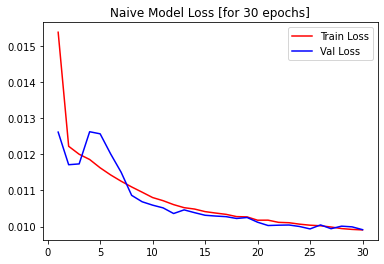

In [18]:
plt.plot(epochs, train_naive, color="red")
plt.plot(epochs, val_naive, color="blue")
plt.title("Naive Model Loss [for 30 epochs]")
plt.legend(["Train Loss", "Val Loss"])
plt.show()

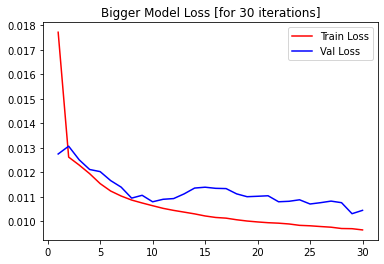

In [19]:
plt.plot(epochs, train_bigger, color="red")
plt.plot(epochs, val_bigger, color="blue")
plt.title("Bigger Model Loss [for 30 iterations]")
plt.legend(["Train Loss", "Val Loss"])
plt.show()

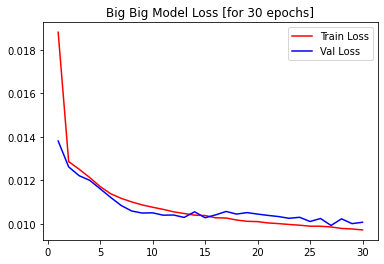

In [20]:
plt.plot(epochs, train_bb, color="red")
plt.plot(epochs, val_bb, color="blue")
plt.title("Big Big Model Loss [for 30 epochs]")
plt.legend(["Train Loss", "Val Loss"])
plt.show()

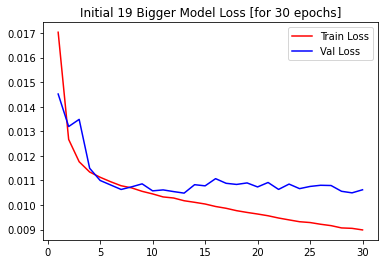

In [22]:
plt.plot(epochs, train_loss_bigger_initial19, color="red")
plt.plot(epochs, val_loss_bigger_initial19, color="blue")
plt.title("Initial 19 Bigger Model Loss [for 30 epochs]")
plt.legend(["Train Loss", "Val Loss"])
plt.show()

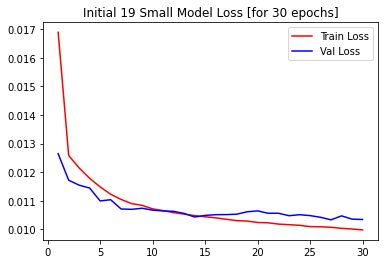

In [23]:
plt.plot(epochs, train_loss_small_initial19, color="red")
plt.plot(epochs, val_loss_small_initial19, color="blue")
plt.title("Initial 19 Small Model Loss [for 30 epochs]")
plt.legend(["Train Loss", "Val Loss"])
plt.show()

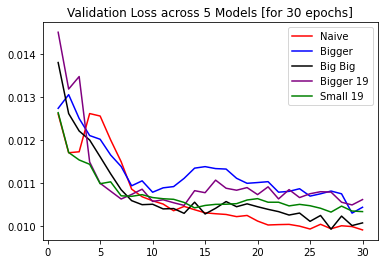

In [24]:
plt.plot(epochs, val_naive, color="red")
plt.plot(epochs, val_bigger, color="blue")
plt.plot(epochs, val_bb, color="black")
plt.plot(epochs, val_loss_bigger_initial19, color="purple")
plt.plot(epochs, val_loss_small_initial19, color="green")
plt.title("Validation Loss across 5 Models [for 30 epochs]")
plt.legend(["Naive", "Bigger", "Big Big", "Bigger 19", "Small 19"])
plt.show()

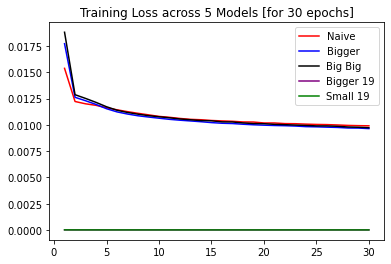

In [25]:
plt.plot(epochs, train_naive, color="red")
plt.plot(epochs, train_bigger, color="blue")
plt.plot(epochs, train_bb, color="black")
plt.plot(epochs, train_loss_bigger_initial19 / len(train_data), color="purple")
plt.plot(epochs, train_loss_small_initial19 / len(train_data), color="green")
plt.title("Training Loss across 5 Models [for 30 epochs]")
plt.legend(["Naive", "Bigger", "Big Big", "Bigger 19", "Small 19"])
plt.show()

In [26]:
np.savetxt("train_naive.csv", train_naive, delimiter=",")
np.savetxt("train_bigger.csv", train_bigger, delimiter=",")
np.savetxt("train_bigbig.csv", train_bb, delimiter=",")

np.savetxt("val_naive.csv", val_naive, delimiter=",")
np.savetxt("val_bigger.csv", val_bigger, delimiter=",")
np.savetxt("val_bigbig.csv", val_bb, delimiter=",")

In [ ]:
# train on multiple cars per
import time

batch_sz = 100
train_data = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_data.dataset))

model = Trajectory().to(device)

my_optim = torch.optim.Adam(model.parameters(), lr=0.001)

# decayRate = 0.999
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)

epoch = 30  # takes around 20 epochs to converge
number = 5  # number of cars in each

for i in range(epoch):

    model.train()
    epoch_loss = 0
    start = time.time()

    train_loop = tqdm(enumerate(train_data), total=len(train_data))

    for i_batch, sample_batch in train_loop:

        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        v_criteria = nn.MSELoss()
        v_loss = torch.sqrt(v_criteria(pred[1], v_out))

        loss = p_loss + v_loss
        epoch_loss += p_loss.item()

        my_optim.zero_grad()
        loss.backward()
        my_optim.step()

        train_loop.set_description(f"Train Epoch [{i + 1}/{epoch}]")
        train_loop.set_postfix(loss = epoch_loss)

    
    filename = "best.pth"
    state = {
        "epoch": i,
        "state_dict": model.state_dict(),
        "optimizer": my_optim.state_dict(),
    }
    torch.save(state, filename)
    print("saved")

In [ ]:
'''
Bigger Bigger Net
/200
30 epochs
'''

# train on multiple cars per
import time

batch_sz = 100
train_data = DataLoader(
    train_dataset,
    batch_size=batch_sz,
    shuffle=False,
    collate_fn=my_collate_train_multiple,
    num_workers=2,
)

print("\nLENGTH OF TRAIN LOADER DATASET:", len(train_data.dataset))

model = Trajectory().to(device)

my_optim = torch.optim.Adam(model.parameters(), lr=0.001)

# decayRate = 0.999
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)

epoch = 30  # takes around 20 epochs to converge
number = 5  # number of cars in each

for i in range(epoch):

    model.train()
    epoch_loss = 0
    start = time.time()

    train_loop = tqdm(enumerate(train_data), total=len(train_data))

    for i_batch, sample_batch in train_loop:

        inp, out = sample_batch
        batch = inp.shape[1]

        p_in, orig = zeroNormTor(inp[0].reshape(batch * number, 19, 2).to(device))
        v_in = inp[1].reshape(batch * number, 19, 2).to(device) / 85.0
        p_out, _ = zeroNormTor(
            out[0].reshape(batch * number, 30, 2).to(device), 30, orig
        )
        v_out = out[1].reshape(batch * number, 30, 2).to(device) / 85.0

        pred = model(p_in, v_in)

        loss = 0
        p_criteria = nn.MSELoss()
        p_loss = torch.sqrt(p_criteria(pred[0], p_out))

        v_criteria = nn.MSELoss()
        v_loss = torch.sqrt(v_criteria(pred[1], v_out))

        loss = p_loss + v_loss
        epoch_loss += p_loss.item()

        my_optim.zero_grad()
        loss.backward()
        my_optim.step()

        train_loop.set_description(f"Train Epoch [{i + 1}/{epoch}]")
        train_loop.set_postfix(loss = epoch_loss)

    
    filename = "best-bb.pth"
    state = {
        "epoch": i,
        "state_dict": model.state_dict(),
        "optimizer": my_optim.state_dict(),
    }
    torch.save(state, filename)
    print("saved")

In [ ]:
model.eval()
load = True 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
initial = 0

model.eval()

if(load):
  checkpoint = torch.load('best.pth')
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
  initial += int(checkpoint['epoch'])

batch_sz = 100
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate_train_multiple, num_workers=2)

epoch_loss =0
batch = 60
number = 5

for i_batch, sample_batch in enumerate(train_loader):
  inp, out = sample_batch
  batch = inp.shape[1]

  p_in = (inp[0].reshape(batch*number,19,2).to(device))/4800.
  v_in = (inp[1].reshape(batch*number,19,2).to(device)+85.)/170.
  p_out = (out[0].reshape(batch*number,30,2).to(device))/4800.
  v_out = (out[1].reshape(batch*number,30,2).to(device)+85.)/170.

  pred = model(p_in, v_in)
  loss = 0
  p_criteria = nn.MSELoss()
  p_loss = torch.sqrt(p_criteria(pred[0], p_out))

  epoch_loss += p_loss.item()
  print(pred[0][10]*4800., p_out[10]*4800.)
  break
  
print("Validation Loss: ", epoch_loss)

In [ ]:
import csv

load = True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
initial = 0

model.eval()

if load:
    checkpoint = torch.load("best.pth")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint["epoch"]))
    initial += int(checkpoint["epoch"])


temp = []

new_path = "data/new_val_in/"
val_dataset = ArgoverseDataset(data_path=new_path)

top = []
top.append("ID")
for i in range(60):
    top.append("v" + str(i + 1))
temp.append(top)

batch = 60
number = 1

with torch.no_grad():
    for i in val_dataset:
        row = []
        scene = i["scene_idx"]
        agent = i["agent_id"]
        target = 0
        for x in range(len(i["track_id"])):
            if i["track_id"][x][0] == agent:
                target = x

        p_in = torch.LongTensor(i["p_in"])
        v_in = torch.LongTensor(i["v_in"])

        p_in, orig = zeroNormTor(p_in.reshape(batch * number, 19, 2).to(device))
        v_in = (v_in.reshape(batch * number, 19, 2).to(device)) / 85.

        pred = model(p_in, v_in)
        
        t = torch.unsqueeze(orig, 1)
        t = torch.repeat_interleave(t, 30, 1)
        

        pred_out = (pred[0] * 200) + t

        output = pred_out[target]

        row.append(scene)
        row = row + torch.flatten(output).cpu().detach().numpy().tolist()
        temp.append(row)

with open("submission22-bigger-200-30.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(temp)